In [1]:
import pandas as pd
from torch.utils.data import DataLoader,Dataset, Subset
import numpy as np
import tft_model
from data_formatters import ts_dataset  
import data_formatters.base
import expt_settings.configs
import importlib
from data_formatters import utils
import torch.optim as optim
import torch
from tqdm import tqdm
import pickle
import time

In [2]:
pd.set_option('max_columns', 1000)

In [3]:
importlib.reload(utils)

<module 'data_formatters.utils' from '/home/arda/Desktop/thesis/submodules/Temporal_Fusion_Transform/data_formatters/utils.py'>

In [4]:
ExperimentConfig = expt_settings.configs.ExperimentConfig

config = ExperimentConfig('m5', 'outputs')

with open('data_formatter_m5.pkl', 'rb') as input:
    data_formatter = pickle.load(input)

# data_formatter = config.make_data_formatter()


# print("*** Training from defined parameters for {} ***".format('m4'))
# data_csv_path = '/home/arda/Desktop/thesis/m5_tft_data.csv'
# print("Loading & splitting data...")
# raw_data = pd.read_csv(data_csv_path, index_col=0)
# print(raw_data.shape)
# start = time.time()
# train, valid, test = data_formatter.split_data(raw_data)
# train_samples, valid_samples = data_formatter.get_num_samples_for_calibration(
# )
# print(time.time()-start)

# with open('train_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(train, output, pickle.HIGHEST_PROTOCOL)

with open('train_m5.pkl', 'rb') as input:
    train = pickle.load(input)

# with open('valid_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(valid, output, pickle.HIGHEST_PROTOCOL)

# with open('test_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(test, output, pickle.HIGHEST_PROTOCOL)
    
# with open('data_formatter_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(data_formatter, output, pickle.HIGHEST_PROTOCOL)

In [5]:
# Sets up default params
fixed_params = data_formatter.get_experiment_params()
params = data_formatter.get_default_model_params()

fixed_params.update(params)
fixed_params['batch_first'] = True
fixed_params['name'] = 'test'
fixed_params['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
fixed_params['minibatch_size'] = 256
# fixed_params['category_count'] = [6]
device = fixed_params['device']
fixed_params['quantiles'] = [0.5]

In [6]:
max_samples = 128 * 500 * 2
# elect = ts_dataset.TSDataset(fixed_params, max_samples, train)

# with open('ts_dataset_m5.pkl', 'wb') as output:  # Overwrites any existing file.
#     pickle.dump(elect, output, pickle.HIGHEST_PROTOCOL)

with open('ts_dataset_m5.pkl', 'rb') as input:
    elect = pickle.load(input)

In [7]:
loader = DataLoader(
            elect,
            batch_size=fixed_params['minibatch_size'],
            num_workers=2,
            shuffle=True
        )

In [8]:
fixed_params

{'total_time_steps': 224,
 'num_encoder_steps': 196,
 'num_epochs': 100,
 'early_stopping_patience': 5,
 'multiprocessing_workers': 5,
 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>),
  ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>),
  ('quantity', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>),
  ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>),
  ('wday', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>),
  ('store_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('item_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('dept_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('cat_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>),
  ('state_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)],
 'input_size'

In [9]:
importlib.reload(tft_model)
model = tft_model.TFT(fixed_params).to(device)

{'total_time_steps': 224, 'num_encoder_steps': 196, 'num_epochs': 100, 'early_stopping_patience': 5, 'multiprocessing_workers': 5, 'column_definition': [('id', <DataTypes.CATEGORICAL: 1>, <InputTypes.ID: 4>), ('date', <DataTypes.DATE: 2>, <InputTypes.TIME: 5>), ('quantity', <DataTypes.REAL_VALUED: 0>, <InputTypes.TARGET: 0>), ('sell_price', <DataTypes.REAL_VALUED: 0>, <InputTypes.KNOWN_INPUT: 2>), ('wday', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('month', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('year', <DataTypes.CATEGORICAL: 1>, <InputTypes.KNOWN_INPUT: 2>), ('store_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('item_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('dept_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('cat_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>), ('state_id', <DataTypes.CATEGORICAL: 1>, <InputTypes.STATIC_INPUT: 3>)], 'input_size': 10, 'output_size': 1, 'cat

In [10]:
from losses.quantile_loss import QuantileLoss
from losses.smape_loss import SMAPELoss
from losses.rmsse_loss import RMSSELoss
from losses.pinball_loss import PinballLoss


q_loss_func = RMSSELoss(fixed_params['device'])
# q_loss_func = SMAPELoss(fixed_params['device'])
# q_loss_func = QuantileLoss(fixed_params['quantiles'])
# import sys
# sys.path.append('/home/arda/Desktop/thesis/')
# from loss_modules import PinballLoss
# q_loss_func = PinballLoss(0.45, device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [11]:
model.train()
epochs=100
losses = []
for i in range(epochs):
    epoch_loss = [] 
    progress_bar = tqdm(enumerate(loader), total=len(loader))
    for batch_num, batch in progress_bar:
        batch['inputs'][batch['inputs'] !=batch['inputs']] = 0
        optimizer.zero_grad()
        output, all_inputs, attention_components = model(batch['inputs'])
        loss = q_loss_func(output.squeeze(2), batch['outputs'][:,:,0].float().to(device))

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), fixed_params['max_gradient_norm'])
        optimizer.step()
        epoch_loss.append(loss.item())
    
    losses.append(np.mean(epoch_loss))
    if loss.item() <= min(losses):
        torch.save(model.state_dict(), 'm5_best_model_rmsse_loss.pth')
        
    print(np.mean(epoch_loss))
    

  0%|          | 0/500 [00:00<?, ?it/s]/home/arda/Desktop/thesis/submodules/Temporal_Fusion_Transform/layers/scaled_dot_product_attention.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mmask = (-1e+9) * (1. - torch.tensor(mask, dtype=torch.float).to(self.device)) # setting to infinity
100%|██████████| 500/500 [04:23<00:00,  1.90it/s]

0.3774272164702415



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.3607607028484344



100%|██████████| 500/500 [04:23<00:00,  1.90it/s]

0.35657393008470534



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.35480772840976715



100%|██████████| 500/500 [04:14<00:00,  1.96it/s]

0.3524414753913879



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.35219939923286436



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3504354347586632



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.34973391038179397



100%|██████████| 500/500 [04:14<00:00,  1.96it/s]

0.3495030963420868



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.34864002734422683



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.3484712940454483



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3474954934120178



100%|██████████| 500/500 [04:18<00:00,  1.93it/s]

0.34795233368873596



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3472456382513046



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3457463982105255



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.34541080296039584



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.34497339046001435



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3454126483798027



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3443798293471336



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.34441480934619906



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3436880542039871



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.34307298904657363



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3436723399758339



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3432691815495491



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3422721988558769



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3415319029092789



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.34192699509859087



100%|██████████| 500/500 [04:15<00:00,  1.95it/s]

0.34116775494813917



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.34073642152547834



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.3403807182312012



100%|██████████| 500/500 [04:14<00:00,  1.96it/s]

0.34017655181884765



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.339932725250721



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.33920645356178286



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3397213148474693



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3389898347854614



100%|██████████| 500/500 [04:15<00:00,  1.96it/s]

0.3388708628416061



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3385009754896164



100%|██████████| 500/500 [04:22<00:00,  1.91it/s]

0.33829292792081833



100%|██████████| 500/500 [04:15<00:00,  1.95it/s]

0.33818444836139677



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.33791246703267097



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.33767613875865937



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.33787467461824416



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3373501881957054



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3373739800453186



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3369078922867775



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3366530972719193



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3366399427652359



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.33606765097379687



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3359419549107552



100%|██████████| 500/500 [04:17<00:00,  1.95it/s]

0.33589579445123674



100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

0.33566497725248334



100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

0.335735491335392



100%|██████████| 500/500 [04:19<00:00,  1.92it/s]

0.3348410992026329



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.3347115535140038



100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

0.33534081262350085



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3340359870195389



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.33424847942590713



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3339868118166924



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.33366462343931197



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3346867666244507



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.33334774804115297



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.33372657614946366



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3335638177394867



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3326199736595154



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.33329289680719376



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3327446272969246



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3321965793073177



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.33116020357608794



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.33249720960855483



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3312879447340965



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.33064632189273835



100%|██████████| 500/500 [04:20<00:00,  1.92it/s]

0.3314456341862679



100%|██████████| 500/500 [04:18<00:00,  1.93it/s]

0.33132613509893416



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.33074364548921587



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3314801279306412



100%|██████████| 500/500 [04:22<00:00,  1.91it/s]

0.33180462491512297



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.33085396480560303



100%|██████████| 500/500 [04:17<00:00,  1.95it/s]

0.3307141033709049



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3301104950904846



100%|██████████| 500/500 [04:18<00:00,  1.93it/s]

0.33004191917181014



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3298944661617279



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.32911065047979354



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.32929334819316863



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.32859183531999586



100%|██████████| 500/500 [04:19<00:00,  1.92it/s]

0.3290180154442787



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3286757486462593



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.32835588544607164



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.32895383358001706



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3283955861926079



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3273208504319191



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3272411925792694



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.32697636651992795



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.32760624498128893



100%|██████████| 500/500 [04:18<00:00,  1.94it/s]

0.3263174026608467



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3271251679062843



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.3262668450474739



100%|██████████| 500/500 [04:16<00:00,  1.95it/s]

0.3269821611046791



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.32623463147878645



100%|██████████| 500/500 [04:17<00:00,  1.94it/s]

0.3260144373178482



100%|██████████| 500/500 [04:19<00:00,  1.93it/s]

0.325911184489727


11


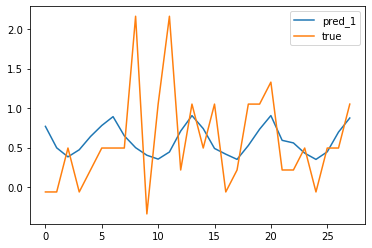

In [18]:
import matplotlib.pyplot as plt
import numpy as np

ind = np.random.choice(64)
print(ind)
plt.plot(output[ind,:,0].detach().cpu().numpy(), label='pred_1')
# plt.plot(output[ind,:,1].detach().cpu().numpy(), label='pred_5')
# plt.plot(output[ind,:,2].detach().cpu().numpy(), label='pred_9')

plt.plot(batch['outputs'][ind,:,0], label='true')
plt.legend()

In [13]:
output[ind,:,0].detach().cpu().numpy()

array([ 0.02837966,  0.04658411, -0.03211647, -0.00769688, -0.02620662,
       -0.02749503,  0.01615772,  0.06485794,  0.02665678,  0.00115144,
       -0.02058155, -0.02917826,  0.00859665,  0.01027825,  0.05261578,
        0.04283697, -0.01290657, -0.02868003, -0.03029686, -0.00198095,
       -0.02477759,  0.04344744,  0.05010738, -0.00238413, -0.0194678 ,
       -0.02087453, -0.01562624, -0.00468886], dtype=float32)